In [1]:
import numpy as np
from scipy.sparse import diags
from scipy import signal
from scipy import stats
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import time
import matplotlib.animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
matplotlib.rcParams['animation.embed_limit'] = 2**128



from workhorse import *
from ploting import *

In [2]:
e = 1.602176634e-19
hbar = 1.054571817e-34
m = 9.1093837015e-31
sigmaX = 200e-10
centerX = 35e-8
L = 3000e-9
vMax = 90e-3 * e
scaleTime = 0.05
bigT = 3/4
Nsteps = 10001
krampus = 1.0



dbTDParameters = {
    "center": 1500e-9,
    "vMax": vMax,
    "barrierWidth": 1.6e-9,
    "wellWidth": 6e-9,
    "potentialVar": 15e-3 * e,
    "phaseLeft": 0,
    "phaseRight": 0
}

dbTDParameters["begining"] = dbTDParameters["center"] - (0.5*dbTDParameters["wellWidth"] + dbTDParameters["barrierWidth"])
dbTDParameters["end"] = dbTDParameters["center"] + (0.5*dbTDParameters["wellWidth"] + dbTDParameters["barrierWidth"])



In [33]:
def singleOscillations(initialEnergy, resonantEnergy):


    initialValues = [e, hbar, m, initialEnergy, sigmaX, centerX, L, vMax, scaleTime, bigT, Nsteps]

    dbTDParameters["freqRight"] = 0
    dbTDParameters["freqLeft"] = (resonantEnergy-initialEnergy)/hbar

    dbTDWaveL = tdWavePropagation(initializePsi, dbTD, initialValues, dbTDParameters, 3000)

    dbTDParameters["freqRight"] = (resonantEnergy-initialEnergy)/hbar
    dbTDParameters["freqLeft"] = 0

    dbTDWaveR = tdWavePropagation(initializePsi, dbTD, initialValues, dbTDParameters, 3000)

    dbTDParameters["freqRight"] = 0
    dbTDParameters["freqLeft"] = 0

    staticWave = tdWavePropagation(initializePsi, dbTD, initialValues, dbTDParameters, 3000)

    freqL, refAmpL, transAmpL = fourierTransform(dbTDWaveL, initialValues, -1, dbTDParameters)
    freqR, refAmpR, transAmpR = fourierTransform(dbTDWaveR, initialValues, -1, dbTDParameters)
    freqS, refAmpS, transAmpS = fourierTransform(staticWave, initialValues, -1, dbTDParameters)

    left = [freqL, refAmpL, transAmpL]
    right = [freqR, refAmpR, transAmpR]
    static = [freqS, refAmpS, transAmpS]

    return static, left, right



In [3]:
def phaseShiftOscillations(initialEnergy, resonantEnergy, phaseShift1, phaseShift2, which = 'right'):


    initialValues = [e, hbar, m, initialEnergy, sigmaX, centerX, L, vMax, scaleTime, bigT, Nsteps, krampus]

    dbTDParameters["freqRight"] = (resonantEnergy-initialEnergy)/hbar
    dbTDParameters["freqLeft"] = (resonantEnergy-initialEnergy)/hbar

    if(which == 'right'):
        dbTDParameters["phaseRight"] = phaseShift1
        dbTDParameters["phaseLeft"] = 0
    if(which == 'left'):
        dbTDParameters["phaseLeft"] = phaseShift1
        dbTDParameters["phaseRight"] = 0

    dbTDWave1 = tdWavePropagation(initializePsi, dbTD, initialValues, dbTDParameters, 3000)

    dbTDParameters["freqRight"] = (resonantEnergy-initialEnergy)/hbar
    dbTDParameters["freqLeft"] = (resonantEnergy-initialEnergy)/hbar
    
    if(which == 'right'):
        dbTDParameters["phaseRight"] = phaseShift2
        dbTDParameters["phaseLeft"] = 0
    if(which == 'left'):
        dbTDParameters["phaseLeft"] = phaseShift2
        dbTDParameters["phaseRight"] = 0

    dbTDWave2 = tdWavePropagation(initializePsi, dbTD, initialValues, dbTDParameters, 3000)

    freqL, refAmpL, transAmpL = fourierTransform(dbTDWave1, initialValues, -1, dbTDParameters)

    freqS, refAmpS, transAmpS = fourierTransform(dbTDWave2, initialValues, -1, dbTDParameters)

    shift1 = [freqL, refAmpL, transAmpL]

    shift2 = [freqS, refAmpS, transAmpS]

    return  shift1, shift2
    
def plotSpectrumPhase(case1, case2, title1 = "Energy Spectrum: Phase Shift", title2 = "Energy Spectrum: Phase Shift", Limits = [20e-3, 50e-3, 0, 2e11]):

    energySpectrum(case1[0], case1[1], case1[2], title = title1, limits = Limits)
    energySpectrum(case2[0], case2[1], case2[2], title = title2, limits = Limits)


In [4]:
phase1 = (1/6)*np.pi
phase2 = (1/4)*np.pi
phase3 = (1/2)*np.pi
phase4 = np.pi

eDiff = 1.0e-3 * e
resonantE = 29.537e-3*e

initE = resonantE - eDiff

In [5]:
phased1, phased2 = phaseShiftOscillations(initE, resonantE, phase1, phase2, which = 'left')
phased3, phased4 = phaseShiftOscillations(initE, resonantE, phase3, phase4, which = 'left')

In [6]:
def phaseDifference(leftTop, rightTop, leftBot, rightBot, angle1, angle2, angle3, angle4, lims = [20e-3, 40e-3, -0, 1.4], figsizeInput = [12, 12]):
    e = 1.602176634e-19
    hbar = 1.054571817e-34
    m = 9.1093837015e-31

    freq1 = leftTop[0]
    freq2 = rightTop[0]
    freq3 = leftBot[0]
    freq4 = rightBot[0]

    energySpec1 = ( (freq1)* hbar)**2/(2 * m)*1e3
    energySpec2 = ( (freq2)* hbar)**2/(2 * m)*1e3
    energySpec3 = ( (freq3)* hbar)**2/(2 * m)*1e3
    energySpec4 = ( (freq4)* hbar)**2/(2 * m)*1e3

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (figsizeInput[0], figsizeInput[1]))
    fig.suptitle(f"Energy spectra for different phase differences. $E_{0}$ = {initE*(1e3/e):.1f} meV. $\hbar\omega$ ={(resonantE-initE)*(1e3/e):.1f} meV")
    plt.xlim(lims[0]*1e3, lims[1]*1e3)
    plt.ylim(lims[2], lims[3])




    ax1.plot(energySpec1/e, leftTop[1]*1e-11, label = "Reflected")
    ax1.plot(energySpec1/e, leftTop[2]*1e-11, label = "Transmited")


    ax2.plot(energySpec2/e, rightTop[1]*1e-11, label = "Reflected")
    ax2.plot(energySpec2/e, rightTop[2]*1e-11, label = "Transmited")

    ax3.plot(energySpec3/e, leftBot[1]*1e-11, label = "Reflected")
    ax3.plot(energySpec3/e, leftBot[2]*1e-11, label = "Transmited")

    ax4.plot(energySpec4/e, rightBot[1]*1e-11, label = "Reflected")
    ax4.plot(energySpec4/e, rightBot[2]*1e-11, label = "Transmited")




    ax1.text(24, 1.01, "(a)", fontsize='xx-large')
    ax2.text(24, 1.01, "(b)", fontsize='xx-large')
    ax3.text(24, 1.01, "(c)", fontsize='xx-large')
    ax4.text(24, 1.01, "(d)", fontsize='xx-large')

    ax1.legend(loc = 'upper right')
    ax2.legend(loc = 'upper right')
    ax3.legend(loc = 'upper right')
    ax4.legend(loc = 'upper right')

    ax1.set_title(f"Phase Difference {angle1*(180/np.pi):.1f}°")
    ax2.set_title(f"Phase Difference {angle2*(180/np.pi):.1f}°")
    ax3.set_title(f"Phase Difference {angle3*(180/np.pi):.1f}°")
    ax4.set_title(f"Phase Difference {angle4*(180/np.pi):.1f}°")


    ax1.grid(which = 'both')
    ax2.grid(which = 'both')
    ax3.grid(which = 'both')
    ax4.grid(which = 'both')

    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.1))

    ax3.set_xlabel("Energy [meV]")
    ax4.set_xlabel("Energy [meV]")

    ax1.set_ylabel("Intensity [Arb. Units]")
    ax3.set_ylabel("Intensity [Arb. Units]")

    

In [7]:
limits = [23e-3, 36e-3, 0, 1.2]
figSize = [12, 12]

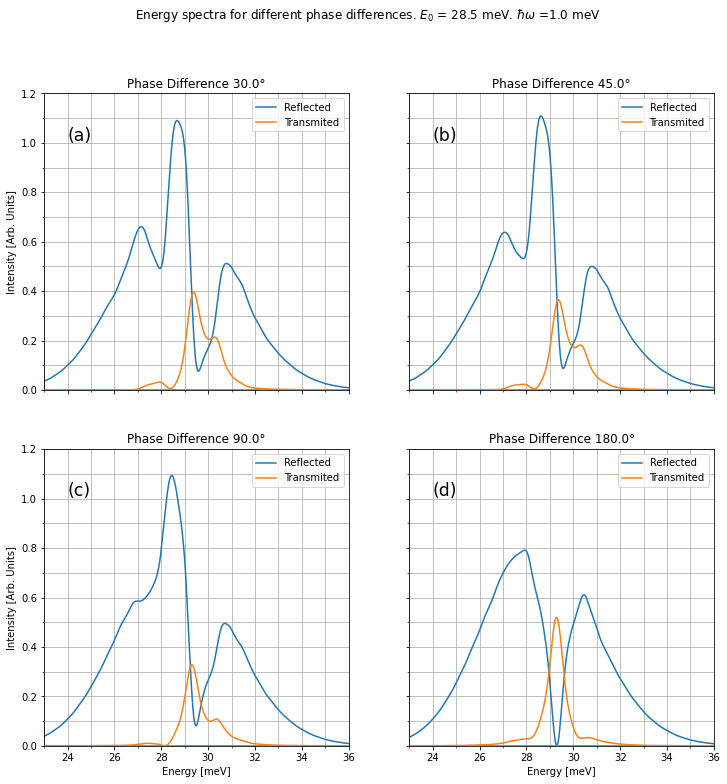

In [8]:
phaseDifference(phased1, phased2, phased3, phased4, phase1, phase2, phase3, phase4, lims=limits, figsizeInput=figSize)

In [9]:
eDiff = 1.5e-3 * e
resonantE = 29.537e-3*e

initE = resonantE - eDiff

In [10]:
phased5, phased6 = phaseShiftOscillations(initE, resonantE, phase1, phase2, which = 'left')
phased7, phased8 = phaseShiftOscillations(initE, resonantE, phase3, phase4, which = 'left')

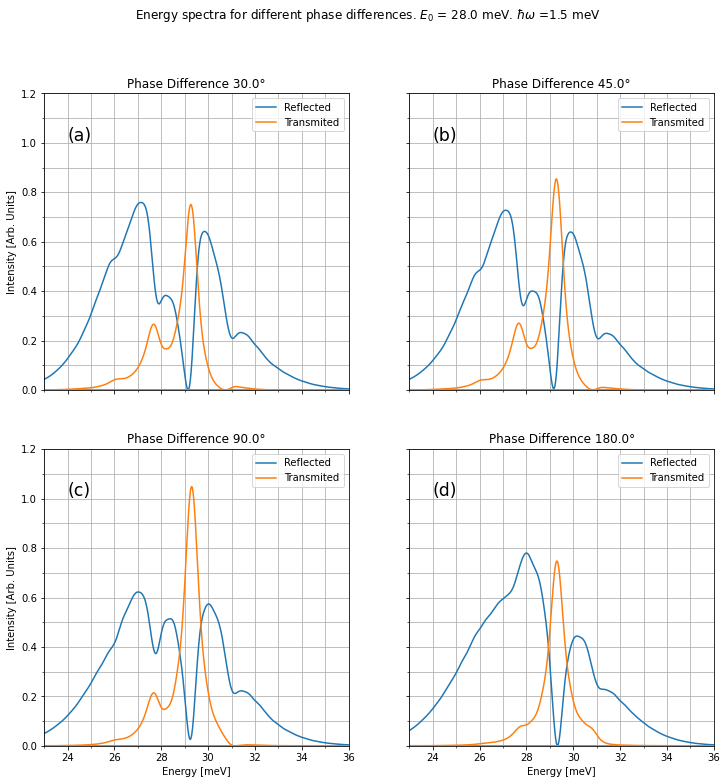

In [11]:
phaseDifference(phased5, phased6, phased7, phased8, phase1, phase2, phase3, phase4, lims=limits, figsizeInput=figSize)

In [12]:
eDiff = 2.0e-3 * e
resonantE = 29.537e-3*e

initE = resonantE - eDiff

In [13]:
phased9, phased10 = phaseShiftOscillations(initE, resonantE, phase1, phase2, which = 'left')
phased11, phased12 = phaseShiftOscillations(initE, resonantE, phase3, phase4, which = 'left')

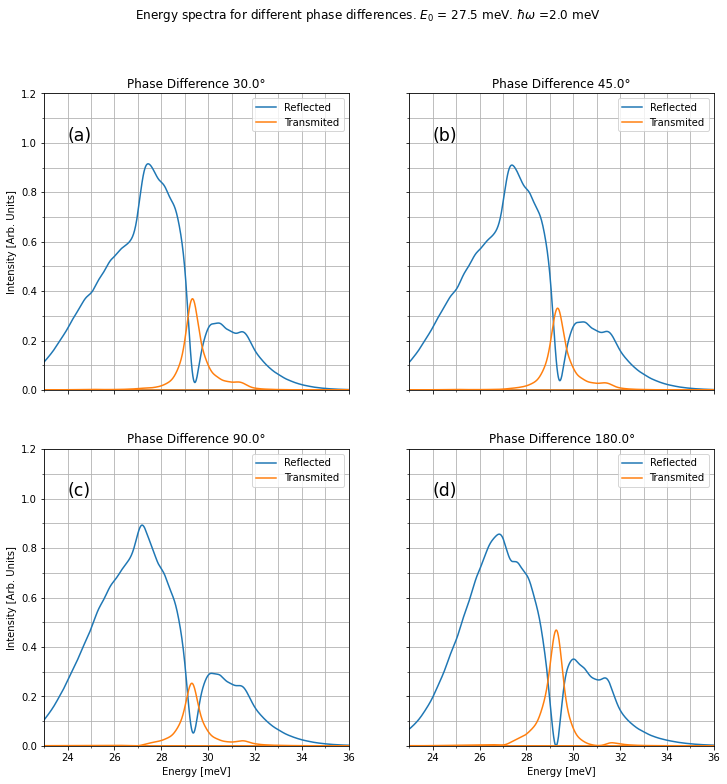

In [14]:
phaseDifference(phased9, phased10, phased11, phased12, phase1, phase2, phase3, phase4, lims=limits, figsizeInput=figSize)